# Predicting Cab Cancellation
This dataset is taken from the kaggle competetion https://inclass.kaggle.com/c/predicting-cab-booking-cancellations/data

In [2]:
# load packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

# custom pipeline classes
import pandas_pipeline_classes as pdpc

# to compute the direct distance
from geographiclib.geodesic import Geodesic
import math
geod = Geodesic.WGS84  # define the WGS84 ellipsoid

# matplotlib settings
matplotlib.style.use('seaborn')

# to import/export models
from sklearn.externals import joblib
import dill

# Setting the ast_node_interactivity to "all" will print
# each statement, not only the last one of a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Load Data

In [3]:
df = pd.read_csv("data/Kaggle_YourCabs_training.csv")
df.head()
df.info()
df.nunique()
df.describe()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1.0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1.0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1.0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1.0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 20 columns):
id                     43431 non-null int64
user_id                43431 non-null int64
vehicle_model_id       43431 non-null int64
package_id             7550 non-null float64
travel_type_id         43431 non-null int64
from_area_id           43343 non-null float64
to_area_id             34293 non-null float64
from_city_id           16345 non-null float64
to_city_id             1588 non-null float64
from_date              43431 non-null object
to_date                25541 non-null float64
online_booking         43431 non-null int64
mobile_site_booking    43431 non-null int64
booking_created        43431 non-null object
from_lat               43338 non-null float64
from_long              43338 non-null float64
to_lat                 34293 non-null float64
to_long                34293 non-null float64
Car_Cancellation       43431 non-null int64
Cost_of_error          43431 non-nu

id                     43431
user_id                22267
vehicle_model_id          27
package_id                 7
travel_type_id             3
from_area_id             598
to_area_id               568
from_city_id               3
to_city_id               116
from_date              20377
to_date                22151
online_booking             2
mobile_site_booking        2
booking_created        39349
from_lat                 466
from_long                462
to_lat                   450
to_long                  447
Car_Cancellation           2
Cost_of_error             70
dtype: int64

## Explanation to the different attributes

* **id** - booking ID
* **user_id** - the ID of the customer (based on mobile number)
* **vehicle_model_id** - vehicle model type.
* **package_id** - type of package (1=4hrs & 40kms, 2=8hrs & 80kms, 3=6hrs & 60kms, 4= 10hrs & 100kms, 5=5hrs & 50kms, 6=3hrs & 30kms, 7=12hrs & 120kms)
* **travel_type_id** - type of travel (1=long distance, 2= point to point, 3= hourly rental).
* **from_area_id** - unique identifier of area. Applicable only for point-to-point travel and packages
* **to_area_id** - unique identifier of area. Applicable only for point-to-point travel
* **from_city_id** - unique identifier of city
* **to_city_id** - unique identifier of city (only for intercity)
* **from_date** - time stamp of requested trip start
* **to_date** - time stamp of trip end
* **online_booking** - if booking was done on desktop website
* **mobile_site_booking** - if booking was done on mobile website
* **booking_created** - time stamp of booking
* **from_lat** - latitude of from area
* **from_long** -  longitude of from area
* **to_lat** - latitude of to area
* **to_long** - longitude of to area
* **Car_Cancellation** (available only in training data) - whether the booking was cancelled (1) or not (0) due to unavailability of a car.
* **Cost_of_error** (available only in training data) - the cost incurred if the booking is misclassified. For an un-cancelled booking, the cost of misclassificaiton is 1. For a cancelled booking, the cost is a function of the cancellation time relative to the trip start time (see Evaluation Page).

A lot of missing values in **to_date, to_lat, to_long, from_city_id, to_city_id, to_area_id, package_id**

## Create Preprocessing Pipelines

In [4]:
# copy data
data = df.copy()

In [296]:
X, y = data.drop('Car_Cancellation', axis=1), data['Car_Cancellation']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [6]:
# list of features
temp_features = ['from_date', 'booking_created']
dist_features = ['from_lat', 'from_long', 'to_lat', 'to_long']
rem_features = ['online_booking', 'mobile_site_booking', 'travel_type_id', 'from_area_id']

### Temporal Pipeline

In [7]:
# custom named functions needed for temporal pipeline
def get_diff(X):
    X['diff_fromDate_bookingCreated'] = X['from_date'] - X['booking_created']
    def tosec(x):
        return x.total_seconds()
    X['diff_fromDate_bookingCreated'] = X['diff_fromDate_bookingCreated'].apply(tosec)
    return X
def get_timeOfDay(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'        
    
def get_season(timestamp):
    month = timestamp.month
    if 3 <= month < 6:
        return 'spring'
    if 6 <= month < 9:
        return 'summer'
    if 9 <= month < 12:
        return 'fall'
    else:
        return 'winter'
    
def get_dayOfWeek(x):
    weekDict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
            4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    return weekDict[x.dayofweek]
def replace_weird_times(x):
    return x if x > 0 else np.nan 

In [8]:
temp_pipe = Pipeline([
    ('select_temporal_columns', pdpc.ColumnSelector(cols=temp_features)),
    ('to_dateTime', pdpc.DataTypeTransformer(dataType='dateTime')),
    ('diff_booking', pdpc.DFTransform(get_diff)),
    ('get_season', pdpc.DFApply(col='from_date', resCol='from_season', func=get_season)),
    ('get_timeOfDay', pdpc.DFApply(col='from_date', resCol='from_timeOfDay', func=get_timeOfDay)),
    ('get_dayOfWeek', pdpc.DFApply(col='from_date', resCol='from_dayOfWeek', func=get_dayOfWeek)),
    ('replace_weird_times', pdpc.DFApply(col='diff_fromDate_bookingCreated',
                                         resCol='diff_fromDate_bookingCreated', func=replace_weird_times)),
    ('fillnan_diff_booking', pdpc.DFImputer(col='diff_fromDate_bookingCreated', method='median')),
    ('scaler', pdpc.DFScaler(scaler='StandardScaler', col='diff_fromDate_bookingCreated'))
])

### Distance Pipeline

In [9]:
class GetDistance(TransformerMixin):
    
    def __init__(self, lat1, long1, lat2, long2, resultCol, copy=True):
        self.copy = copy
        self.lat1 = lat1
        self.lat2 = lat2
        self.long1 = long1
        self.long2 = long2
        self.resultCol = resultCol
        
    # cumbersome
    def __computeDist__(self, X):
        X_ = X if not self.copy else X.copy()
        return geod.Inverse(X_[self.lat1], X_[self.long1] ,
                                    X_[self.lat2], X_[self.long2] )['s12'] / 1000
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_ = X if not self.copy else X.copy()
        X_[self.resultCol] = X_.apply(self.__computeDist__, axis=1)
        return X_

In [10]:
distance_pipe = Pipeline([
    ('select_distance_columns', pdpc.ColumnSelector(dist_features)),
    ('get_distance', GetDistance('from_lat', 'from_long', 'to_lat', 'to_long', 'direct_distance')),
    ('fillnan_direct_distance', pdpc.DFImputer(col='direct_distance', method='median')),
    ('drop', pdpc.DropColumns(['from_lat','from_long','to_lat','to_long'])),
    ('scaler', pdpc.DFScaler(scaler='StandardScaler', col='direct_distance'))
])

###  Pipeline for the remaining attributes

In [11]:
rem_pipe = Pipeline([
    ('select_rem_columns', pdpc.ColumnSelector(rem_features)),
    ('transform_to_str', pdpc.DataTypeTransformer(dataType='str'))
])

### combine preprocessing pipes

In [14]:
prep_pipe = Pipeline([
    ('parallel_pipe', pdpc.DFFeatureUnion([
            ('temp', temp_pipe),
            ('dist', distance_pipe),
            ('rem', rem_pipe)
    ])),
    ('dropCols', pdpc.DropColumns(cols=temp_features + ['direct_distance', 'diff_fromDate_bookingCreated'])),
    ('getDummies', pdpc.DFDummyTransformer()),
    ('addMissingRemAdd', pdpc.DFAddMissingCatCols()),
    ])

### test preprocessing pipe 

In [16]:
prep_pipe.fit_transform(X_train, y_train).head()

,diff_fromDate_bookingCreated_scaled,direct_distance_scaled,from_area_id=1004.0,from_area_id=1005.0,from_area_id=1008.0,from_area_id=1010.0,from_area_id=1012.0,from_area_id=1013.0,from_area_id=1014.0,from_area_id=1015.0,...,from_timeOfDay=evening,from_timeOfDay=morning,from_timeOfDay=night,mobile_site_booking=0,mobile_site_booking=1,online_booking=0,online_booking=1,travel_type_id=1,travel_type_id=2,travel_type_id=3
2109,-0.302530,2.298404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
14673,0.328455,1.079044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1057,-0.333465,-0.782491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3806,-0.314797,0.130229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
24149,-0.355512,-1.026255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [184]:
# best params after hyperopt search
bbc_params = {'bbc__base_estimator__learning_rate': 0.21902366660705558, 'bbc__base_estimator__max_depth': 7, 'bbc__base_estimator__min_samples_leaf': 3, 'bbc__base_estimator__min_samples_split': 3, 'bbc__base_estimator__n_estimators': 200, 'bbc__n_estimators': 100, 'bbc__n_jobs': 5} 

In [187]:
# import the model: prep_pipe + balancedBag(GradientBoost)
cab_pipe_bbc_gb = dill.load(open('cab_pipe_bbc_gb.pkl', 'rb'))
cab_pipe_bbc_gb.set_params(**bbc_params)

In [ ]:
# set default pipe (without parameter tuning)
cab_pipe_default = dill.load(open('cab_pipe_bbc_gb.pkl', 'rb'))
bbc_params_default = {'bbc__base_estimator__n_estimators': 200, 'bbc__n_estimators': 100, 'bbc__n_jobs': 5}
cab_pipe_default.set_params(**bbc_params)

### Fit Models

In [189]:
cab_pipe_bbc_gb.fit(X_train, y_train)
cab_pipe_default.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('parallel_pipe', DFFeatureUnion(transformer_list=[('temp', Pipeline(memory=None,
     steps=[('select_temporal_columns', ColumnSelector(cols=['from_date', 'booking_created'])), ('to_dateTime', DataTypeTransformer(cols=['from_date', 'booking_created'], copy=True,
          dataType='dateTime'...     random_state=None, ratio='auto', replacement=False, verbose=0,
             warm_start=False))])

In [271]:
y_pred, y_pred_proba = cab_pipe_bbc_gb.predict(X_test), cab_pipe_bbc_gb.predict_proba(X_test)
y_pred_default, y_pred_proba_default = cab_pipe_default.predict(X_test), cab_pipe_default.predict_proba(X_test)

(0.0, 1.0)

(0.0, 1.0)

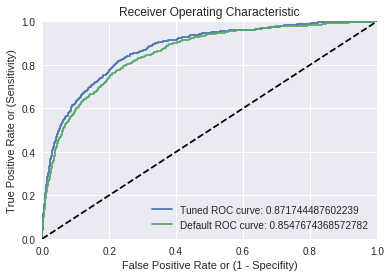

In [273]:
%matplotlib inline
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, y_pred_proba_default[:,1])

# are under roc curve
roc_auc = auc(fpr,tpr)
roc_auc_default = auc(fpr_default,tpr_default)

# Plot ROC curve
plt.plot(fpr, tpr, label='Tuned ROC curve: {}'.format(roc_auc))
plt.plot(fpr_default, tpr_default, label='Default ROC curve: {}'.format(roc_auc_default))

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')

plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

In [269]:
# http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

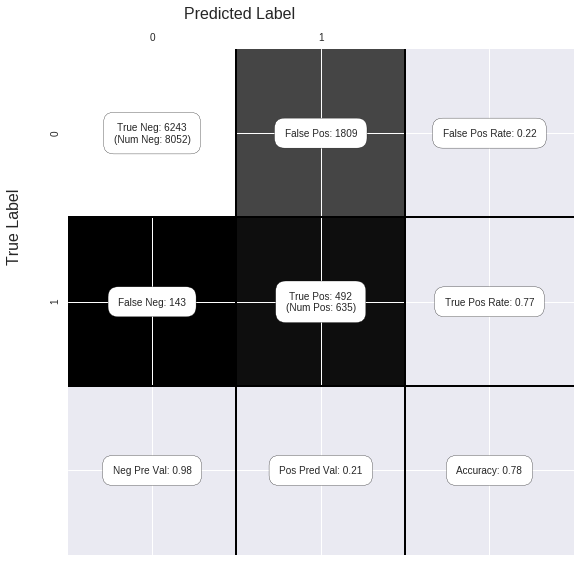

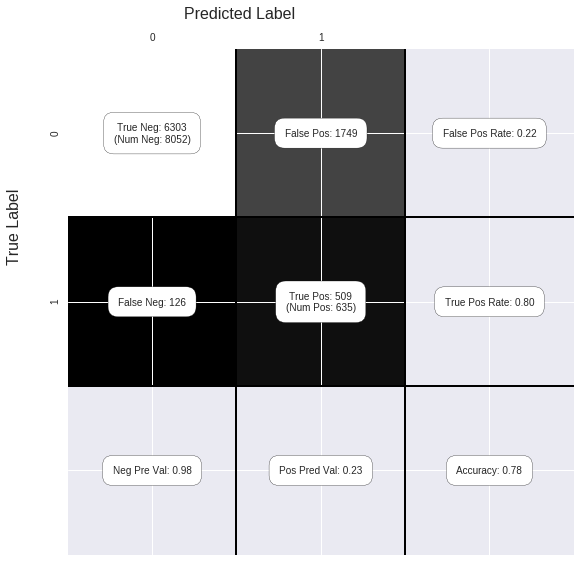

In [275]:
conf_tuned = confusion_matrix(y_pred=y_pred, y_true=y_test)
conf_default = confusion_matrix(y_pred=y_pred_default, y_true=y_test)

show_confusion_matrix(conf_default)
show_confusion_matrix(conf_tuned)

In [285]:
# prec recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:,1])
precision_default, recall_default, thresholds_default = precision_recall_curve(y_test, y_pred_proba_default[:,1])

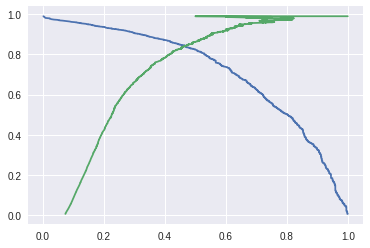

In [290]:
plt.plot(recall[:-1], thresholds, label='test')
plt.plot(precision[:-1], thresholds, label='test')

## kaggle scores

In [299]:
%%time
# train with the full dataset
cab_pipe_bbc_gb.fit(X, y)
cab_pipe_default.fit(X, y)
print("Training done")

Training done
CPU times: user 2min 32s, sys: 1.52 s, total: 2min 33s
Wall time: 31min 6s


In [300]:
X_score = pd.read_csv("data/Kaggle_YourCabs_score.csv")
myY = cab_pipe_bbc_gb.predict(X_score)
myY_default = cab_pipe_default.predict(X_score)

In [301]:
res = pd.DataFrame({'Car_Cancellation': myY, 'id':X_score.id}, columns=['id', 'Car_Cancellation'])
res_default = pd.DataFrame({'Car_Cancellation': myY_default, 'id':X_score.id}, columns=['id', 'Car_Cancellation'])

In [302]:
res.to_csv('my_res.csv', index=False)
res_default.to_csv('my_res_default.csv', index=False)

## Feature importance

In [327]:
pipe = cab_pipe_bbc_gb.steps[:-1]
gb = [('gb',cab_pipe_bbc_gb.steps[-1][1].base_estimator)]
gb_pipe = Pipeline(pipe + gb)
gb_pipe.fit(X,y)

Pipeline(memory=None,
     steps=[('parallel_pipe', DFFeatureUnion(transformer_list=[('temp', Pipeline(memory=None,
     steps=[('select_temporal_columns', ColumnSelector(cols=['from_date', 'booking_created'])), ('to_dateTime', DataTypeTransformer(cols=['from_date', 'booking_created'], copy=True,
          dataType='dateTime'...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [330]:
forest = gb_pipe.steps[-1][1]
importance_list = forest.feature_importances_.tolist()
features_list = prep_pipe.transform(X_train).columns.tolist()

In [366]:
# get feature importance sorted
def get_featureImportance(features_list, importance_list):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(features_list, importance_list):
        feats[feature] = importance #add the name/value pair
    importancesDF = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
    imp_list = importancesDF.index.tolist()
    imp_set = list(set([element.split('=')[0] for element in imp_list]))
    impDict = {}
    for element in imp_set:
        impDict[element] = importancesDF.filter(regex=element, axis=0).sum()
    return pd.DataFrame.from_dict(impDict, orient='index').sort_values(by='importance',axis=0, ascending=False)

In [367]:
importanceDF = get_featureImportance(features_list, importance_list)

,importance
diff_fromDate_bookingCreated_scaled,0.276807
from_area_id,0.203028
direct_distance_scaled,0.200973
travel_type_id,0.067231
mobile_site_booking,0.035943
from_timeOfDay,0.030023
online_booking,0.020747
from_dayOfWeek,0.004108
from_season,0.001902


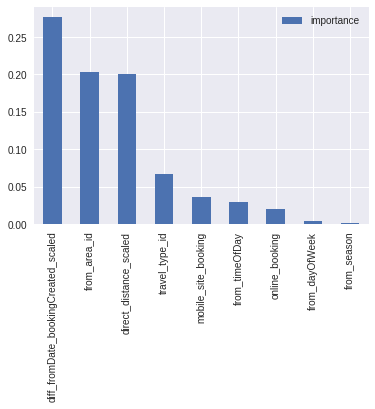

In [368]:
importanceDF
importanceDF.plot(kind='bar')

### explore the features

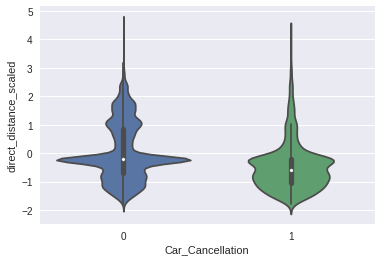

In [374]:
dataDF =pd.concat([prep_pipe.transform(X), y], axis=1)
#    ax = sns.stripplot(data=df, y=element, x='Car_Cancellation',jitter=True, color='gray')
ax = sns.violinplot(data=dataDF, y='direct_distance_scaled', x='Car_Cancellation', inner='box')
plt.show()

In [375]:
# skewness
print("skewness (Schiefheit):")
df.groupby('Car_Cancellation').skew().transpose()

skewness (Schiefheit):


Car_Cancellation,0,1
Cost_of_error,0.000000,-6.680960
from_area_id,0.101981,0.011442
from_city_id,-9.527800,0.000000
from_lat,1.196998,1.299525
from_long,-0.119677,-0.600825
id,0.022582,-0.374764
mobile_site_booking,4.733281,2.818978
online_booking,0.714965,-0.440933
package_id,1.897191,1.053949
to_area_id,0.536899,0.035144


### analyze trials

In [376]:
trials = dill.load(open('/home/jodahr/Programs/hyper_tuning/output/my_model_gb_bbc3.hyperopt', 'rb'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f885fb85fd0>]], dtype=object)

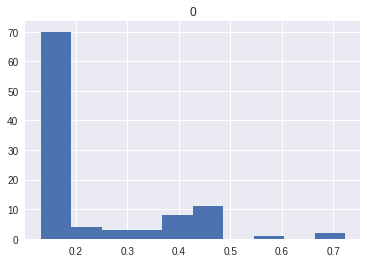

In [378]:
pd.DataFrame(trials.losses()).hist()
plt.show()

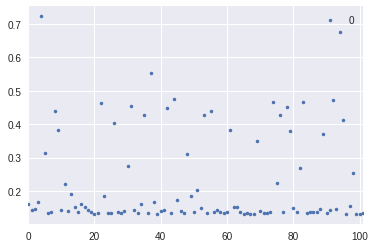

In [399]:
#dict = {markers:'c'}
pd.DataFrame(trials.losses()).plot(marker='.', linestyle='None')
plt.show()

In [403]:
trials.best_trial.values()

dict_values([2, 99, None, {'loss': 0.1315935961974043, 'status': 'ok'}, {'tid': 99, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'bbc__base_estimator__learning_rate': [99], 'bbc__base_estimator__max_depth': [99], 'bbc__base_estimator__min_samples_leaf': [99], 'bbc__base_estimator__min_samples_split': [99], 'bbc__base_estimator__n_estimators': [99], 'bbc__n_estimators': [99], 'bbc__n_jobs': [99]}, 'vals': {'bbc__base_estimator__learning_rate': [0.21902366660705558], 'bbc__base_estimator__max_depth': [6], 'bbc__base_estimator__min_samples_leaf': [2], 'bbc__base_estimator__min_samples_split': [1], 'bbc__base_estimator__n_estimators': [0], 'bbc__n_estimators': [0], 'bbc__n_jobs': [0]}}, None, None, 0, datetime.datetime(2017, 11, 10, 23, 11, 55, 952000), datetime.datetime(2017, 11, 10, 23, 34, 12, 79000)])

In [414]:
#trials.idxs_vals
#trials.idxs

In [425]:
trials.vals['loss'] = trials.losses()
trialDict = {**trials.vals, **{'loss':trials.losses()}}

In [426]:
trialsDF = pd.DataFrame(trialDict)

In [427]:
trialsDF.head()

,bbc__base_estimator__learning_rate,bbc__base_estimator__max_depth,bbc__base_estimator__min_samples_leaf,bbc__base_estimator__min_samples_split,bbc__base_estimator__n_estimators,bbc__n_estimators,bbc__n_jobs,loss
0,0.001801,5,4,1,0,0,0,0.160892
1,0.850961,4,3,2,0,0,0,0.143585
2,0.012065,8,0,2,0,0,0,0.144900
3,0.010029,2,1,4,0,0,0,0.166545
4,2.740852,0,4,4,0,0,0,0.722846


[0.0009, 10.1, 1, 10]

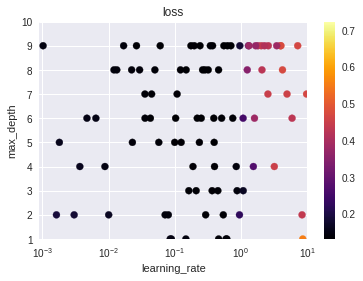

In [473]:
fig, ax = plt.subplots()

sc = ax.scatter(trialsDF.bbc__base_estimator__learning_rate,
           trialsDF.bbc__base_estimator__max_depth, c=trialsDF.loss, cmap='inferno')

fig.colorbar(sc, ax=ax)
#ax.set_aspect("equal")
ax.set_xscale('log')

plt.xlabel('learning_rate')
plt.ylabel('max_depth')
ax.set_autoscale_on(False)
ax.axis([0.0009, 10.1, 1, 10])
plt.title('loss')
plt.show()

### kaggle result screenshots

![alt text](kaggle1.png "Logo Title Text 1")
![alt text](kaggle2.png "Logo Title Text 1")
![alt text](kaggle3.png "Logo Title Text 1")


### ideas for the future

1. stacking with brew
2. robust scaler to take care of outliers
3. voting classifier
4. better features